# Chapter 3: Introducing Snorkel

In this chapter I will introduce [Snorkel](http://snorkel.org), which we'll use throughout the book. [Snorkel](https://www.snorkel.org/) is a software project ([github](https://github.com/snorkel-team/snorkel)) originally from the Hazy Research group at Stanford University enabling the practice of *weak supervision*, *distant supervision*, *data augmentation* and *data slicing*.

The project has an excellent [Get Started](https://www.snorkel.org/get-started/) page, and I recommend you spend some time working the [tutorials](https://github.com/snorkel-team/snorkel-tutorials) before proceeding beyond this chapter. 

Snorkel implements an unsupervised generative model that accepts a matrix of weak labels for records in your training data and produces strong labels by learning the relationships between these weak labels through matrix factorization.

In [144]:
import random
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import pyarrow

from lib import utils


# Make randomness reproducible
random.seed(31337)
np.random.seed(31337)

# Ignore annoying warnings
import warnings
warnings.simplefilter("ignore")

## Example Project: Labeling Amazon Github Repositories

I have previously hand labeled about 2,600 Github repositories belonging to Amazon and its subsidiariesinto categories related to their purpose. We're going to use this dataset to introduce Snorkel.

### Hand Labeling this Data

In order to get a ground truth dataset against which to benchmark our Snorkel labeling, I hand labeled all Amazon Github projects in [this sheet](https://docs.google.com/spreadsheets/d/1wiesQSde5LwWV_vpMFQh24Lqx5Mr3VG7fk_e6yht0jU/edit?usp=sharing). The label categories are:

| Number | Code      | Description                          |
|--------|-----------|--------------------------------------|
| 0      | GENERAL   | A FOSS project of general utility    |
| 1      | API       | API library for AWS / Amazon product |
| 2      | RESEARCH  | A research paper and/or dataset      |
| 3      | DEAD      | Project is dead, no longer useful    |
| 3      | OTHER     | Uncertainty... what is this thing?   |

If you want to make corrections, please open the sheet, click on `File --> Make a Copy`, make any edits and then share the sheet with me.

In [145]:
# Show all columns to see the data menu :)
pd.options.display.max_columns = None

# Load the labeled data made up of Github API data and Github READMEs
df = pd.read_json('../data/amazon_github_repos.json.bz2', lines=True, compression='bz2')

# Trim the fields so we can see the data
df = df[[
    'id',
    'full_name',
    'description',
    'created_at',
    'updated_at',
    'homepage',
    'stargazers_count',
    'watchers',
    'forks',
    'open_issues',
    'license',
    'readme',
    'label'
]]

df['license'] = df['license'].apply(lambda x: x['name'] if x and 'name' in x else '')

# Remove empties to avoid spaCy processing errors
df = df.fillna('')

# Set the index to the project ID
df = df.set_index('id')

df.head()

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,2016-06-24 06:26:05,2020-02-21 22:20:59,,2811,2811,670,8,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API
84138837,alexa/alexa-cookbook,A series of sample code projects to be used fo...,2017-03-07 01:19:08,2020-02-23 04:01:25,,1557,1557,912,13,Other,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,1002,1002,1186,7,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integra...,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,993,993,477,54,Apache License 2.0,### What is the Alexa Voice Service (AVS)?\n\n...,API
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,715,715,720,2,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API


## Profile the Data

Let's take a quick look at the labels to see what we'll be classifying.

In [146]:
print(f'Total records: {len(df.index):,}')

df['label'].value_counts()

Total records: 2,568


API         2265
GENERAL      279
DEAD          14
RESEARCH       9
OTHER          1
Name: label, dtype: int64

### How much general utility do Amazon's Github projects have?

One question that occurs to me to ask is - how much general utility do Amazon's Github projects have? Let's look at the number of `GENERAL` purpose compared to the number of `API` projects.

In [147]:
api_count     = df[df['label'] == 'API'].count(axis='index')['full_name']
general_count = df[df['label'] == 'GENERAL'].count(axis='index')['full_name']

general_pct = 100 * (general_count / (api_count + general_count))
api_pct     = 100 * (api_count / (api_count + general_count))

print(f'Percentage of projects having general utility:   {general_pct:,.3f}%')
print(f'Percentage of projects for Amazon products/APIs: {api_pct:,.3f}%')

Percentage of projects having general utility:   10.967%
Percentage of projects for Amazon products/APIs: 89.033%


### Simplify to `API` vs `GENERAL`

We throw out `DEAD`, `RESEARCH` and `OTHER` to focus on `API` vs `GENERAL` - is an open source project of general utility or is it a client to a company's commercial products? Highly imabalanced classes are hard to deal with when building a classifier, and 1:9 for `GENERAL`:`API` is bad enough.

In [148]:
df = df[df['label'].isin(['API', 'GENERAL'])]

print(f'Total records with API/GENERAL labels: {len(df.index):,}')

df.head()

Total records with API/GENERAL labels: 2,544


,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61861755,alexa/alexa-skills-kit-sdk-for-nodejs,The Alexa Skills Kit SDK for Node.js helps you...,2016-06-24 06:26:05,2020-02-21 22:20:59,,2811,2811,670,8,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API
84138837,alexa/alexa-cookbook,A series of sample code projects to be used fo...,2017-03-07 01:19:08,2020-02-23 04:01:25,,1557,1557,912,13,Other,\n# Alexa Skill Building Cookbook\n\n<div styl...,API
63275452,alexa/skill-sample-nodejs-fact,Build An Alexa Fact Skill,2016-07-13 19:58:38,2020-02-24 10:27:16,,1002,1002,1186,7,Apache License 2.0,"# Build An Alexa Fact Skill\n<img src=""https:/...",API
81483877,alexa/avs-device-sdk,An SDK for commercial device makers to integra...,2017-02-09 18:57:26,2020-02-21 17:10:51,https://developer.amazon.com/avs/sdk,993,993,477,54,Apache License 2.0,### What is the Alexa Voice Service (AVS)?\n\n...,API
38904647,alexa/alexa-skills-kit-sdk-for-java,The Alexa Skills Kit SDK for Java helps you ge...,2015-07-10 22:21:51,2020-02-22 01:37:41,http://developer.amazon.com/ask,715,715,720,2,Apache License 2.0,"<p align=""center"">\n <img src=""https://m.medi...",API


### Split our Data into Training and Validation Data

In order to demonstrate Snorkel's capabilities, we need to create an experiment by splitting our data into three datasets:

* A hand labeled development dataset `dev_df` we will use to determine if our LFs work
* An unlabeled training dataset `train_df` that Snorkel's LabelModel will use to learn the labels
* A hand labeled test dataset `test_df` used to validate that the discriminative model we train with our labeled data works

The point of Snorkel is that you don't need labels - so we won't be using labels with the training dataset, `train_df`. Therefore we delete that variable to keep ourselves honest :) We also keep the development dataset `dev_df` small to demonstrate that you only need to label a small amount of representative data.

Once we've prepared our three dataset splits, because the labeled dev dataset `dev_df` is small, we run a value count for each of its labels to verify we have an adequate number of each label. It looks like we have around ten, which will do. People use Snorkel without any labels at all but at least ten of each label is very helpful in evaluating the performance, as we code, of the data programs we'll be writing to label data/

In [149]:
from sklearn.model_selection import train_test_split

# First split into a dev/train dataset we'll split next and a test dataset for our final model
dev_train_df, test_df, train_labels, test_labels = train_test_split(
    df,
    df['label'],
    test_size=0.75
)

# Then split the dev/train data to create a small labeled dev dataset and a larger unlabeled training dataset
dev_df, train_df, dev_labels, train_labels = train_test_split(
    dev_train_df,
    dev_train_df['label'],
    test_size=0.7
)

# Make sure our split of records makes sense
print(f'Total dev records:   {len(dev_df.index):,}')
print(f'Total train records: {len(train_df.index):,}')
print(f'Total test records:  {len(test_df.index):,}')

# Remove the training data labels - normally we would not have labeled these yet - this is why we're using Snorkel!
del train_labels

# Count labels in the dev set
dev_labels.value_counts(), test_labels.value_counts()

Total dev records:   190
Total train records: 446
Total test records:  1,908


(API        165
 GENERAL     25
 Name: label, dtype: int64, API        1697
 GENERAL     211
 Name: label, dtype: int64)

## Working with Snorkel

Snorkel has three primary programming interfaces: Labeling Functions, Transformation Functions and Slicing Functions.

<img 
     alt="Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions"
     src="images/snorkel_apis_0.9.5.png"
     width="500px"
/>
<div align="center">Snorkel Programming Interface: Labeling Functions, Transformation Functions and Slicing Functions, from <a href="https://www.snorkel.org/">Snorkel.org</a></div>

### Labeling Functions (LFs)

A labeling function is a deterministic function used to label data as belonging to one class or another. They produce weak labels that in combination, through Snorkel’s generative models, can be used to generate strong labels for unlabeled data.

The [Snorkel paper](https://arxiv.org/pdf/1711.10160.pdf) explains that LFs are open ended, that is that they can leverage information from multiple sources - both inside and outside the record. For example LFs can operate over different parts of the input document, working with document metadata, entire texts, individual paragraphs, sentences or words, parts of speech, named entities extracted by preprocessors, text embeddings or any augmentation of the record whatsoever. They can simultaneously leverage external databases and rules through *distant supervision*. These might include vocabulary for keyword searches, heuristics defined by theoretical considerations or equations, 

For example, a preprocessor might run a text document through a language model such as the included `SpacyPreprocessor` to run Named Entity Resolution (NER) and then look for words queried from WikiData that correspond to a given class. There are many ways to write LFs. We’ll define a broad taxonomy and then demonstrate some techniques from each.

The program interface for Labeling Functions is [`snorkel.labeling.LabelingFunction`](https://snorkel.readthedocs.io/en/v0.9.5/packages/_autosummary/labeling/snorkel.labeling.LabelingFunction.html#snorkel.labeling.LabelingFunction). They are instantiated with a name, a function reference, any resources the function needs and a list of any preprocessors to run on the data records before the labeling function runs.

<img alt="LabelingFunction API" src="images/labeling_function_api.png" width="600" />

### Defining Labeling Schema

In order to write our first labeling function, we need to define the label schema for our problem. The first label in any labeling schema is `-1` for `ABSTAIN`, which means "cast no vote" about the class of the record. This allows Snorkel Labeling Functions to vote only when they are certain, and is critical to how the system works since labeling functions have to perform better than random when they do vote or the Label Model won't work well.

The labels for this analysis are:

| Number | Code      | Description                       |
|--------|-----------|-----------------------------------|
| -1     | ABSTAIN   | No vote, for Labeling Functions   |
| 0      | GENERAL   | A FOSS project of general appeal  |
| 1      | API       | An API library for AWS            |

In [150]:
# Define our numeric labels as integers
ABSTAIN = -1
GENERAL = 0
API     = 1


def map_labels(x):
    """Map string labels to integers"""
    if x == 'API':
        return API
    if x == 'GENERAL':
        return GENERAL


dev_labels    =   dev_labels.apply(map_labels, convert_dtype=True)
test_labels   =  test_labels.apply(map_labels, convert_dtype=True)

dev_labels.shape, test_labels.shape

((190,), (1908,))

### Writing our First Labeling Function

In order to write a labeling function, we must describe our data to associate a property with a certain class of records that can be programmed as a heuristic. Let's inspect some of our records. The classes are imbalanced 9:1, so lets pull a stratified sample of both labels.

Look at the data table produced by the records below and try to eyeball any patterns among the `API` and the `GENERAL` records. Do you see any markers for `API` records or `GENERAL` records?

In [151]:
# Set Pandas to display more than 10 rows
pd.set_option('display.max_rows', 100)

api_df     = dev_df[dev_df['label'] ==     'API'].sample(frac=1).head(20).sort_values(by='label')
general_df = dev_df[dev_df['label'] == 'GENERAL'].sample(frac=1).head(10).sort_values(by='label')

api_df.append(general_df).head(30)

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
173388926,aws-samples/aws-sagemaker-ground-truth-recipe,A recipe of SageMaker Ground Truth Lambdas to ...,2019-03-02 01:21:25,2020-02-08 05:07:30,,6,6,6,0,Other,# amazon-cognito-gamelogin-sample\nA basic dem...,API
13098551,aws-samples/emr-bootstrap-actions,This repository hold the Amazon Elastic MapRed...,2013-09-25 16:08:07,2020-02-02 18:24:26,,577,577,308,42,Other,Create a Serverless Pipeline for Video Frame A...,API
198224216,aws-quickstart/quickstart-datasunrise,AWS Quick Start Team,2019-07-22 13:00:32,2020-02-19 13:19:46,,0,0,1,0,Apache License 2.0,# VFS - Virtual File System\n\n**This repo is ...,API
157622659,awslabs/amazon-sqs-java-temporary-queues-client,An Amazon SQS client that supports creating li...,2018-11-14 23:03:03,2020-01-20 05:00:25,,40,40,15,17,Apache License 2.0,AdaTune\n=======\n\nAdaTune is a library to pe...,API
169291664,aws-samples/amazon-kinesis-replay,A Java application that replays events that ar...,2019-02-05 18:36:27,2020-02-24 15:53:29,,5,5,14,0,Other,# Enabling alternative data sources with AWS A...,API
114793971,awsdocs/amazon-kinesis-data-firehose-developer...,The open source version of the Amazon Kinesis ...,2017-12-19 17:39:01,2020-02-04 12:29:18,,16,16,21,8,Other,## Elastic Load Balancing User Guide\n\nThe op...,API
38803545,awslabs/aws-apigateway-sdk-java,,2015-07-09 07:01:14,2020-01-08 04:41:48,,24,24,10,5,Apache License 2.0,# AWS EC2 Snapshot script\n\n## Instalation In...,API
108043478,aws-samples/chalice-workshop,"Contains tutorials, slides, and code for the A...",2017-10-23 21:44:40,2020-01-09 17:49:57,,66,66,31,7,Apache License 2.0,## SageMaker Notebook Instance Lifecycle Confi...,API
17877309,aws-samples/opsworks-attribute-customization,AWS OpsWorks attribute customization example,2014-03-18 18:32:47,2018-07-01 16:41:38,,3,3,5,0,Apache License 2.0,# Attentional ASR Models Misbehave on Out-of-d...,API


### Detecting Patterns

In looking at the `full_name` and `html_url`, it looks like projects with `sdk` in the title are `API` projects. Lets filter down to those records to see.

In [152]:
sdk_df = dev_df[dev_df['full_name'].str.contains('sdk')]

print(f'Total SDK records: {len(sdk_df.index)}')

sdk_df.groupby('label').count()['full_name']

Total SDK records: 8


label
API    8
Name: full_name, dtype: int64

## Building an SDK Labeling Function

There is an 8:0 `API`:`GENERAL` ratio of labels among records with `sdk` in their full_name. This is more than good enough for a Labeling Function (LF), since they only have to be better than random! Cool, eh? Don't worry, the `LabelModel` will figure out which signal from which LF to use :) It's like magic!

This is called a keyword labeling function, the simplest type. Despite their simplicity, keyword LFs are incredibly powerful ways to inject subject matter expertise into a project. In the chapter on Weak Supervision, we'll get into the various types of LFs and the strategies researchers and Snorkel users have come up with for labeling data. For now we'll create this and a couple of other LFs and see where that gets us.

In [153]:
# The verbosse way to define an LF
from snorkel.labeling import LabelingFunction


sdk_lf = LabelingFunction(
    name="name_contains_sdk_lf",
    f=lambda x: API if 'sdk' in x.full_name.lower() else ABSTAIN,
)

print(sdk_lf)


# The short form way to define an LF
from snorkel.labeling import labeling_function


@labeling_function()
def name_contains_sdk_lf(x):
    return API if 'sdk' in x.full_name.lower() else ABSTAIN

print(sdk_lf)

LabelingFunction name_contains_sdk_lf, Preprocessors: []
LabelingFunction name_contains_sdk_lf, Preprocessors: []


## Testing our `LabelingFunction`

Snorkel comes with tools to help you run your LFs on your dataset to see how they perform. We're using Pandas, so we use [`snorkel.labeling.PandasLFApplier`](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.PandasLFApplier.html) to apply our list of label functions (in this case just one) to the hand-labeled development dataset `dev_df` and the unlabeled training dataset `train_df`. Note that there are also `LFAppliers` for [Dask](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.dask.DaskLFApplier.html) and [PySpark](https://snorkel.readthedocs.io/en/latest/packages/_autosummary/labeling/snorkel.labeling.apply.spark.SparkLFApplier.html#snorkel.labeling.apply.spark.SparkLFApplier).

In [154]:
from snorkel.labeling import LFAnalysis
from snorkel.labeling import PandasLFApplier


lfs = [sdk_lf]

# Instantiate our LF applier with our list of LabelFunctions (just one for now)
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 446/446 [00:00<00:00, 25570.48it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.042105,0.0,0.0,8,0,1.0


In [155]:
# Run the same LF analysis on the unlabeled training data, accuracy yet unknown
LFAnalysis(L=L_train,  lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.076233,0.0,0.0


## Interpreting the `LFAnalysis` Summary

Looking at the tables above coverage of our first LF is about 7.6%, which means that it abstains by voting `ABSTAIN`/`-1` 92.4% of the time. In practice we need enough `LabelingFunctions` to cover more of the data than this and we must also write at least one LF per unique tag. Now that we've got an LF for `API`, let's write one for `GENERAL`.

## Writing Another `LabelingFunction`

We need more than just one vote to accurately label our data, so now we're going to inspect the data again and arrive at several more LFs - data programs - to label the data as either `API` or `GENERAL`.

### Inspecting the Development Data

To begin, let's write a function to perform the operation we did above to create a DataFrame showing a mix of `API` and `GENERAL` labels to get a sense of the difference between them. This is the point at which we are injection domain expertise as a form of supervision. Convenient this is about software, as we are the domain experts :)

In [156]:
def stratified_sample(a_df, b_df, labels, n=[20, 10]):
    """Given two pd.DataFrames, their labels and desired ratios, acreate a stratified sample and display n records"""
    a_sample_df = a_df[a_df['label'] == labels[0]].sample(frac=1).head(n[0]).sort_values(by='label')
    b_sample_df = b_df[b_df['label'] == labels[1]].sample(frac=1).head(n[1]).sort_values(by='label')

    return a_df.append(b_df).sample(frac=1.0).head(sum(n))


stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
114793971,awsdocs/amazon-kinesis-data-firehose-developer...,The open source version of the Amazon Kinesis ...,2017-12-19 17:39:01,2020-02-04 12:29:18,,16,16,21,8,Other,## Elastic Load Balancing User Guide\n\nThe op...,API
173205293,awslabs/amplify-mobilehub-migrator,A plugin to migrate existing AWS Mobile Hub pr...,2019-02-28 23:53:12,2020-02-06 20:13:13,https://amplify.aws,6,6,4,8,Apache License 2.0,## AWS CRT Node.js\n\nNode.js bindings for the...,API
223239181,aws-samples/amazon-cognito-aspnetcore-webapp-f...,Code and walkthrough labs to set up an asp.net...,2019-11-21 18:34:03,2019-12-10 06:10:21,,2,2,2,0,Other,,API
198224216,aws-quickstart/quickstart-datasunrise,AWS Quick Start Team,2019-07-22 13:00:32,2020-02-19 13:19:46,,0,0,1,0,Apache License 2.0,# VFS - Virtual File System\n\n**This repo is ...,API
54621372,amzn/amazon-dsstne,Deep Scalable Sparse Tensor Network Engine (DS...,2016-03-24 06:57:40,2020-02-21 12:59:49,,4414,4414,761,43,Apache License 2.0,# Sketch Constructor\n\nThis library provides ...,GENERAL
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe b...,2019-04-02 00:07:09,2019-12-03 21:52:57,,2,2,1,0,Apache License 2.0,# GameOn Unity Starter Kit\n\nWith the GameOn ...,GENERAL
72232913,awslabs/ecs-swift-sample-app,,2016-10-28 18:39:34,2019-09-18 03:27:14,,8,8,6,0,Apache License 2.0,# Analyzing Text with Amazon Elasticsearch Ser...,API
30425273,c9/c9.ide.ace.gotoline,"The repository for c9.ide.ace.gotoline, a Clou...",2015-02-06 17:54:12,2018-02-24 07:33:57,https://c9.io/packages/c9.ide.ace.gotoline,1,1,5,1,MIT License,# lex_node\n\n\n## Overview\nThe ROS `lex_node...,GENERAL
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon ...,2018-02-13 18:05:53,2019-07-03 20:50:47,,4,4,1,1,Apache License 2.0,,GENERAL


### Creating an Ion `LabelingFunction`

I notice that there are two projects labeled `GENERAL` that have the word "ion" in their project name. I happen to know that Ion is Amazon's storage format for complex data, and that it is a project with general utility. 

#### Investingating the "ion"/`GENERAL` Pattern

Let's investigate and if it pans out we'll write another LF. 

In [157]:
dev_df[dev_df['full_name'].str.contains('ion')]

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
120510499,aws-samples/amazon-workmail-demo-ews-push-noti...,A sample application demonstrating the use of ...,2018-02-06 19:13:06,2019-07-15 12:03:35,,9,9,1,0,Apache License 2.0,# Create AWS CloudFormation templates for AWS ...,API
157936916,aws-robotics/aws-robomaker-sample-application-...,Use AWS RoboMaker and demonstrate a robot that...,2018-11-17 00:42:24,2020-02-07 15:21:17,,10,10,7,2,Other,Ace (Ajax.org Cloud9 Editor)\n================...,API
155783103,awslabs/machine-learning-for-telecommunications,A base solution that helps to generate insight...,2018-11-01 22:23:16,2019-11-14 20:25:29,,13,13,18,0,Apache License 2.0,# Configure an LDAPS Endpoint for Simple AD\nC...,API
222004116,awslabs/predictive-segmentation-using-amazon-p...,,2019-11-15 21:13:28,2020-01-23 16:00:51,,2,2,1,0,Apache License 2.0,## cloud-templates-ruby-graphviz\n\nGraphViz r...,API
134776216,aws-samples/aws-media-services-vod-automation,Sample code and CloudFormation scripts for aut...,2018-05-24 22:47:18,2020-02-06 22:40:10,,44,44,30,15,Apache License 2.0,## Amazon Kinesis Video Streams Media Viewer\n...,API
131745508,aws-samples/aws-concurrent-data-orchestration-...,This code demonstrates the architecture featur...,2018-05-01 18:00:46,2020-02-11 15:09:03,,61,61,28,5,Apache License 2.0,## Amazon SageMaker Script Mode Examples\n\nTh...,API
185669865,awslabs/aws-encryption-sdk-specification,AWS Encryption SDK Specification,2019-05-08 19:46:54,2020-02-19 17:56:27,,8,8,7,55,Other,# Stale Playlist Detector (SPD)\n\n## Overview...,API
182169480,aws-samples/gitlab-to-codecommit-migration,Script to migrate from GitLab to Amazon CodeCo...,2019-04-18 23:14:47,2020-01-15 12:58:58,,2,2,2,0,Other,# 1. Overview\n\nThere are multiple options av...,API
101670463,amzn/oss-contribution-tracker,Track contributions made to external projects ...,2017-08-28 17:45:55,2020-02-14 16:05:52,,32,32,9,6,Apache License 2.0,spree_pay_with_amazon\n===================\n\n...,GENERAL


#### Iterating on our Pattern

Ah, it looks like "ion" isn't good enough, as it is picking up lots of other words with "ion" in them. Lets try "/ion" since the examples we can see have that pattern"

In [158]:
dev_df[dev_df['full_name'].str.contains('/ion')]

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon ...,2018-02-13 18:05:53,2019-07-03 20:50:47,,4,4,1,1,Apache License 2.0,,GENERAL
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe b...,2019-04-02 00:07:09,2019-12-03 21:52:57,,2,2,1,0,Apache License 2.0,# GameOn Unity Starter Kit\n\nWith the GameOn ...,GENERAL
145019226,amzn/ion-hive-serde,A Apache Hive SerDe (short for serializer/dese...,2018-08-16 17:24:56,2019-10-31 19:35:21,,6,6,1,7,Apache License 2.0,# Amazon AIA SDK\n\nThis repository contains r...,GENERAL


Looks better! While 3:0 is not overwhelming support I happen to know there are many Ion projects and it is likely they mostly follow this pattern. Remember, `LabelingFunctions` don't have to be perfect - they just have to perform better than random. The magic of Snorkel's `LabelModel` is that it is unsupervised and models the interactions between LFs as a generative, graphical model it then uses to predict strong labels. When combined, these LFs give the model enough signal work do its job, turning multiple weak labels into one strong label.

### Writing the Ion Labeling Function

Now that we have the pattern, we can write another keyword LF.

In [159]:
@labeling_function()
def name_contains_slash_ion(x):
    return GENERAL if '/ion' in x.full_name.lower() else ABSTAIN


# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 446/446 [00:00<00:00, 19238.15it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.042105,0.0,0.0,8,0,1.0
name_contains_slash_ion,1,[0],0.015789,0.0,0.0,3,0,1.0


In [160]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.076233,0.0,0.0
name_contains_slash_ion,1,[0],0.008969,0.0,0.0


### Evaluating the LF Analysis

This LF works but has low coverage. We'll have to do better in terms of coverage if we're going to do a good job labeling `GENERAL` projects!

### Writing Another `LabelingFunction`

Again let's inspect the data and look what pops out.

In [161]:
stratified_sample(api_df, general_df, ['API', 'GENERAL'])

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
223239181,aws-samples/amazon-cognito-aspnetcore-webapp-f...,Code and walkthrough labs to set up an asp.net...,2019-11-21 18:34:03,2019-12-10 06:10:21,,2,2,2,0,Other,,API
54621372,amzn/amazon-dsstne,Deep Scalable Sparse Tensor Network Engine (DS...,2016-03-24 06:57:40,2020-02-21 12:59:49,,4414,4414,761,43,Apache License 2.0,# Sketch Constructor\n\nThis library provides ...,GENERAL
211173264,amzn/amazon-hub-counter-sdk-java,The Amazon Hub Counter SDK for Java enables Ja...,2019-09-26 20:11:19,2019-12-03 08:46:59,,0,0,0,0,Other,# AWS Cloud Development Kit (AWS CDK)\n\n![Bui...,API
121417140,amzn/ion-test-driver,A cross-implementation test driver for Amazon ...,2018-02-13 18:05:53,2019-07-03 20:50:47,,4,4,1,1,Apache License 2.0,,GENERAL
177178352,aws-samples/amazon-comprehend-doc-search,"Using Amazon Comprehend, Amazon Elasticsearch ...",2019-03-22 16:54:18,2020-02-14 00:41:37,,10,10,5,1,Other,## Amazon Comprehend Document Search\n\nUsing ...,API
94918280,awslabs/iot-button-notifications,A Lambda function to configure an AWS IoT Butt...,2017-06-20 17:36:14,2019-05-30 01:17:59,,5,5,6,1,Other,## AWS IoT Core Websockets\n\n[![Build Status]...,API
13098551,aws-samples/emr-bootstrap-actions,This repository hold the Amazon Elastic MapRed...,2013-09-25 16:08:07,2020-02-02 18:24:26,,577,577,308,42,Other,Create a Serverless Pipeline for Video Frame A...,API
198224216,aws-quickstart/quickstart-datasunrise,AWS Quick Start Team,2019-07-22 13:00:32,2020-02-19 13:19:46,,0,0,1,0,Apache License 2.0,# VFS - Virtual File System\n\n**This repo is ...,API
178966086,amzn/ion-kotlin-builder,This library provides Kotlin style type-safe b...,2019-04-02 00:07:09,2019-12-03 21:52:57,,2,2,1,0,Apache License 2.0,# GameOn Unity Starter Kit\n\nWith the GameOn ...,GENERAL


### Investigating Quick Start LFs

I see a pattern wherein proejct names with "quickstart" and project descriptions with "Quick Start" seem to be `API` projects. Let's see if we're right by isolating and inspecting these records and then counting the number of labels for this subset.

In [162]:
# First look for quickstart in the full name
quickstart_name_df = dev_df[dev_df['full_name'].str.contains('quickstart')]
quickstart_name_df

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61231696,aws-quickstart/quickstart-microsoft-wapadfs,AWS Quick Start Team,2016-06-15 18:38:15,2020-02-23 11:49:47,,9,9,14,2,Apache License 2.0,# connect-integration-webtext\n## Amazon Conne...,API
172607988,aws-quickstart/quickstart-sap-datahub-eks,AWS Quick Start Team,2019-02-26 00:31:35,2020-02-04 20:25:05,,4,4,2,0,Apache License 2.0,# connect-integration-teleopti-wfm\n## Amazon ...,API
150444544,aws-quickstart/quickstart-suse-cloud-applicati...,AWS Quick Start Team,2018-09-26 14:59:34,2020-02-23 08:00:41,,4,4,10,24,Apache License 2.0,# quickstart-microfocus-amc-es\n## Micro Focus...,API
207576991,aws-quickstart/connect-integration-deloitte-tr...,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,2,2,1,0,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\...,API
68962380,aws-quickstart/quickstart-hashicorp-vault,AWS Quick Start Team,2016-09-22 21:09:05,2020-02-17 02:57:51,,60,60,32,6,Apache License 2.0,quickstart-microsoft-utilities\n==============...,API
79190058,aws-quickstart/quickstart-tableau-awsdata,AWS Quick Start Team,2017-01-17 04:58:37,2020-02-10 12:13:24,,11,11,12,2,Apache License 2.0,# quickstart-compliance-cjis\n## Standardized ...,API
105202575,aws-quickstart/quickstart-illumina-dragen,AWS Quick Start Team,2017-09-28 21:50:01,2020-01-29 21:52:26,,8,8,7,2,Apache License 2.0,# quickstart-chef-automate\n## Chef Automate o...,API
164793761,aws-quickstart/quickstart-duo-mfa,AWS Quick Start Team,2019-01-09 05:24:31,2020-02-11 04:15:00,,0,0,9,8,Apache License 2.0,# Architect\n\nArchitect is a simple but power...,API
198224216,aws-quickstart/quickstart-datasunrise,AWS Quick Start Team,2019-07-22 13:00:32,2020-02-19 13:19:46,,0,0,1,0,Apache License 2.0,# VFS - Virtual File System\n\n**This repo is ...,API


In [163]:
quickstart_name_df['label'].value_counts()

API    11
Name: label, dtype: int64

In [164]:
quickstart_desc_df = dev_df[dev_df['description'].str.lower().str.contains('quick start')]
quickstart_desc_df

,full_name,description,created_at,updated_at,homepage,stargazers_count,watchers,forks,open_issues,license,readme,label
id,,,,,,,,,,,,
61231696,aws-quickstart/quickstart-microsoft-wapadfs,AWS Quick Start Team,2016-06-15 18:38:15,2020-02-23 11:49:47,,9,9,14,2,Apache License 2.0,# connect-integration-webtext\n## Amazon Conne...,API
172607988,aws-quickstart/quickstart-sap-datahub-eks,AWS Quick Start Team,2019-02-26 00:31:35,2020-02-04 20:25:05,,4,4,2,0,Apache License 2.0,# connect-integration-teleopti-wfm\n## Amazon ...,API
150444544,aws-quickstart/quickstart-suse-cloud-applicati...,AWS Quick Start Team,2018-09-26 14:59:34,2020-02-23 08:00:41,,4,4,10,24,Apache License 2.0,# quickstart-microfocus-amc-es\n## Micro Focus...,API
207576991,aws-quickstart/connect-integration-deloitte-tr...,AWS Quick Start Team,2019-09-10 14:08:46,2020-01-24 17:43:16,,2,2,1,0,Apache License 2.0,# quickstart-hitrust-csf\n## HITRUST on AWS\n\...,API
68962380,aws-quickstart/quickstart-hashicorp-vault,AWS Quick Start Team,2016-09-22 21:09:05,2020-02-17 02:57:51,,60,60,32,6,Apache License 2.0,quickstart-microsoft-utilities\n==============...,API
79190058,aws-quickstart/quickstart-tableau-awsdata,AWS Quick Start Team,2017-01-17 04:58:37,2020-02-10 12:13:24,,11,11,12,2,Apache License 2.0,# quickstart-compliance-cjis\n## Standardized ...,API
105202575,aws-quickstart/quickstart-illumina-dragen,AWS Quick Start Team,2017-09-28 21:50:01,2020-01-29 21:52:26,,8,8,7,2,Apache License 2.0,# quickstart-chef-automate\n## Chef Automate o...,API
164793761,aws-quickstart/quickstart-duo-mfa,AWS Quick Start Team,2019-01-09 05:24:31,2020-02-11 04:15:00,,0,0,9,8,Apache License 2.0,# Architect\n\nArchitect is a simple but power...,API
198224216,aws-quickstart/quickstart-datasunrise,AWS Quick Start Team,2019-07-22 13:00:32,2020-02-19 13:19:46,,0,0,1,0,Apache License 2.0,# VFS - Virtual File System\n\n**This repo is ...,API


In [165]:
quickstart_desc_df['label'].value_counts()

API    11
Name: label, dtype: int64

### Evaluating Quick Start Strategy

So it looks like both the `full_name` pattern of `quickstart` (14 `API` labels) and the lowercase `description` pattern of `quick start` (14 `API` labels) both work on the same number of records, but I suspect the coverage of both will be better than one alone. The description pattern matches two more records, otherwise they fully overlap. I'm going to leave both LFs in and move on to writing more LFs before we deal with evaluating results.

In [166]:
@labeling_function()
def name_contains_quickstart(x):
    return API if 'quickstart' in x.full_name.lower() else ABSTAIN


@labeling_function()
def desc_contains_quickstart(x):
    return API if 'quick start' in x.description.lower() else ABSTAIN

In [167]:
# Update our list of LFs to include this one
lfs = [name_contains_sdk_lf, name_contains_slash_ion, name_contains_quickstart, desc_contains_quickstart]

# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 446/446 [00:00<00:00, 11599.19it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
name_contains_sdk_lf,0,[1],0.042105,0.000000,0.0,8,0,1.0
name_contains_slash_ion,1,[0],0.015789,0.000000,0.0,3,0,1.0
name_contains_quickstart,2,[1],0.057895,0.057895,0.0,11,0,1.0
desc_contains_quickstart,3,[1],0.057895,0.057895,0.0,11,0,1.0


In [168]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
name_contains_sdk_lf,0,[1],0.076233,0.000000,0.0
name_contains_slash_ion,1,[0],0.008969,0.000000,0.0
name_contains_quickstart,2,[1],0.080717,0.076233,0.0
desc_contains_quickstart,3,[1],0.076233,0.076233,0.0


## Utilities for Creating Keyword LFs

We'll be creating several keyword labeling functions, so we're going to write some utility functions to make this more efficient. These come from the Snorkel Spam tutorial, and later we'll extend their capabilities to remove the need to write code for keyword LFs.

In [250]:
def keyword_lookup(x, keywords, field, label):
    """Given a list of tuples, look for any of a list of keywords"""
    
    if isinstance(keywords, str):
        keywords = [keywords]
    
    if isinstance(field, str):
        if field in x and x[field] and any(word.lower() in getattr(x, field).lower() for word in keywords):
            return label
        return ABSTAIN
    
    if isinstance(field, list):
        for f in field:
            if f in x and x[f] and any(word.lower() in getattr(x, f).lower() for word in keywords):
                return label
        return ABSTAIN


def make_keyword_lf(keywords, field, label=ABSTAIN):
    """Given a list of keywords and a label, return a keyword search LabelingFunction"""
    
    field_name = field
    if isinstance(field, list):
        field_name = '_'.join(field)
    
    keyword_name = keywords
    if isinstance(keywords, list):
        keyword_name = '_'.join(keywords)
    
    name = f'keyword_{keyword_name}_field_{field_name}'        
    
    return LabelingFunction(
        name=name,
        f=keyword_lookup,
        resources=dict(
            keywords=keywords,
            field=field,
            label=label,
        ),
    )

Now we can re-implement our existing UDFs using these utilities and write a few more!

In [260]:
# If it says SDK, it is probably an API library
sdk_lf = make_keyword_lf(
    keywords='sdk',
    field='full_name',
    label=API,
)

# If api is in the name... its an API project
api_lf = make_keyword_lf(
    keywords='api',
    field='full_name',
    label=API,
)

# Walkthroughs be APIs
walkthrough_lf = make_keyword_lf(
    keywords=['walkthrough', 'walk through'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Anything mentioning a skill is usually an Alexa skill example, of which there are many
skill_lf = make_keyword_lf(
    keywords=['skill', 'skills'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Kits be APIs
kit_lf = make_keyword_lf(
    keywords=['kit', 'kits'],
    field=['description', 'readme'],
    label=API,
)

# Extensions are APIs
extension_lf = make_keyword_lf(
    keywords='extension',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
amazon_lf = make_keyword_lf(
    keywords='amazon',
    field=['description', 'readme'],
    label=API,
)

# Add amazon means API
aws_lf = make_keyword_lf(
    keywords='aws',
    field=['full_name', 'description'],
    label=API,
)

# Integrations tend to be about APIs
integration_lf = make_keyword_lf(
    keywords=['integrate', 'integration'],
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Ion is a major GENERAL purpose project
ion_lf = make_keyword_lf(
    keywords='/ion',
    field='full_name',
    label=GENERAL,
)

# Sample tends to indicate API
sample_lf = make_keyword_lf(
    keywords='sample',
    field=['full_name', 'description', 'readme'],
    label=API,
)

# Demos be EDUCATION
demo_lf = make_keyword_lf(
    keywords=['demonstrate', 'demo'],
    field=['full_name', 'description', 'readme'],
    label=API,
)


# Add the LFs to one large list
lfs = [
    sdk_lf,
    api_lf,
    walkthrough_lf,
    skill_lf,
    kit_lf,
    extension_lf,
    amazon_lf,
    aws_lf,
    integration_lf,
    ion_lf,
    sample_lf,
    demo_lf
]
lfs

[LabelingFunction keyword_sdk_field_full_name, Preprocessors: [],
 LabelingFunction keyword_api_field_full_name, Preprocessors: [],
 LabelingFunction keyword_walkthrough_walk through_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_skill_skills_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_kit_kits_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_extension_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_amazon_field_description_readme, Preprocessors: [],
 LabelingFunction keyword_aws_field_full_name_description, Preprocessors: [],
 LabelingFunction keyword_integrate_integration_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_/ion_field_full_name, Preprocessors: [],
 LabelingFunction keyword_sample_field_full_name_description_readme, Preprocessors: [],
 LabelingFunction keyword_demonstrate_demo_field_full_name_description_readme, Preprocessors:

In [261]:
# Create and apply a new Pandas 
applier = PandasLFApplier(lfs=lfs)

# Apply the LFs to the data to generate a list of labels
L_dev   = applier.apply(df=dev_df)
L_train = applier.apply(df=train_df)

# Run an label function analysis on the results, to describe their output against the labeled development data
LFAnalysis(L=L_dev, lfs=lfs).lf_summary(dev_labels.values)

100%|██████████| 446/446 [00:00<00:00, 1305.98it/s]


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
keyword_sdk_field_full_name,0,[1],0.042105,0.042105,0.000000,8,0,1.000000
keyword_api_field_full_name,1,[1],0.021053,0.021053,0.000000,4,0,1.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.047368,0.047368,0.000000,9,0,1.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.068421,0.068421,0.000000,13,0,1.000000
keyword_kit_kits_field_description_readme,4,[1],0.163158,0.157895,0.005263,27,4,0.870968
keyword_extension_field_description_readme,5,[1],0.073684,0.073684,0.000000,13,1,0.928571
keyword_amazon_field_description_readme,6,[1],0.752632,0.742105,0.015789,128,15,0.895105
keyword_aws_field_full_name_description,7,[1],0.826316,0.789474,0.000000,152,5,0.968153
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.189474,0.189474,0.000000,34,2,0.944444
keyword_/ion_field_full_name,9,[0],0.015789,0.015789,0.015789,3,0,1.000000


In [262]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
keyword_sdk_field_full_name,0,[1],0.076233,0.076233,0.000000
keyword_api_field_full_name,1,[1],0.017937,0.017937,0.000000
keyword_walkthrough_walk through_field_full_name_description_readme,2,[1],0.044843,0.044843,0.000000
keyword_skill_skills_field_full_name_description_readme,3,[1],0.071749,0.069507,0.000000
keyword_kit_kits_field_description_readme,4,[1],0.145740,0.143498,0.002242
keyword_extension_field_description_readme,5,[1],0.071749,0.071749,0.002242
keyword_amazon_field_description_readme,6,[1],0.773543,0.757848,0.006726
keyword_aws_field_full_name_description,7,[1],0.843049,0.798206,0.000000
keyword_integrate_integration_field_full_name_description_readme,8,[1],0.181614,0.181614,0.002242
keyword_/ion_field_full_name,9,[0],0.008969,0.008969,0.008969


## Check Overall Label Coverage

We need to check how much of the data is covered by our different labelers in aggregate.

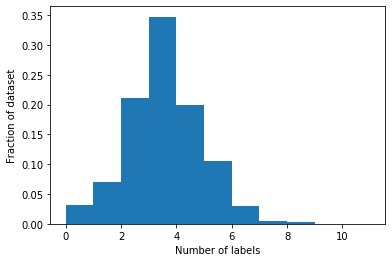

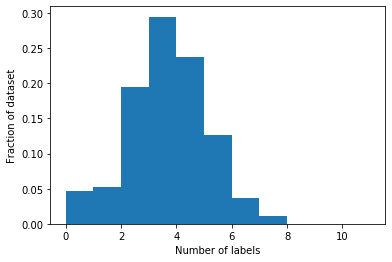

In [264]:
from matplotlib import pyplot as plt


def plot_label_frequency(L):
    plt.hist(
        (L != ABSTAIN).sum(axis=1),
        density=True,
        bins=range(L.shape[1])
    )
    plt.xlabel("Number of labels")
    plt.ylabel("Fraction of dataset")
    plt.show()


plot_label_frequency(L_train)
plot_label_frequency(L_dev)

### Interpretation

The overall label coverage looks good. Now we need to look at each label's coverage.

## Analyze the Labeling Functions' Performance

Overall label coverage is good but we need to make sure the distribution of our LF output is approximately even otherwise the label model won't have enough data with which to make good inferences about how LFs relate.

To help with this, we first prepare a `DataFrame` of label function names and their corresponding text labels to add to the `LFAnalysis.lf_summary` output to make it clearer what the coverage is for each label. 

In [266]:
# Prepare a name/label DataFrame to join to the LF Summary DataFrame below
lf_names = [lf.name for lf in lfs]
lf_labels = [lf._resources['label'] for lf in lfs]
lf_label_names = [{'Labels': number_to_name_dict[l]} for l in lf_labels]
label_name_df = pd.DataFrame(lf_label_names, index=lf_names)
len(label_name_df.index)

NameError: name 'number_to_name_dict' is not defined